In [1]:
import plotly.express as px
import plotly.graph_objects as go
# plotly display option
import plotly.io as pio
pd.options.plotting.backend = 'plotly'
pio.renderers.default = "notebook_connected"
from matplotlib import font_manager, rc

# 운영체제에 맞게 폰트 설정
import platform   # 현재 사용하고 있는 시스템 유형을 알려주는 패키지 
if platform.system() == "Windows":
    # 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
pd.set_option('display.max_columns', None)

# 수입자동차 Model별 데이터

In [2]:
model_df = pd.read_csv("datas/model_data_yearly_0507.csv")
model_df.drop(index=model_df[model_df['BRAND'].str.contains('Total')].index, inplace=True)

In [3]:
model_df['E-D(CC)'] = model_df['E-D(CC)'].astype(int)
model_df['PRICE'] = model_df['PRICE'].astype(int)
model_df

,YEAR,MONTH,BRAND,MODEL,E-D(CC),PRICE,SALES,SHARES(%)
0,2016,1,Audi,A1 30 TDI,1598,32700,0,0.00
1,2016,1,Audi,A1 Sportback 30 TDI,1598,33700,0,0.00
2,2016,1,Audi,A3 25 TDI,1598,37500,0,0.00
3,2016,1,Audi,A3 35 TDI,1968,38900,101,0.62
4,2016,1,Audi,A3 35 TFSI,1798,42900,3,0.02
...,...,...,...,...,...,...,...,...
36412,2021,3,Volvo,XC60 T8 AWD,1969,83200,186,0.68
36413,2021,3,Volvo,XC90 B6 AWD,1969,82600,21,0.08
36414,2021,3,Volvo,XC90 D5 AWD,1969,80300,0,0.00
36415,2021,3,Volvo,XC90 T6 AWD,1969,95500,0,0.00


In [4]:
print(model_df['BRAND'].nunique())
model_df['BRAND'].unique()

26


array(['Audi', 'BMW', 'Bentley', 'Cadillac', 'Chrysler', 'Citroen',
       'Fiat', 'Ford', 'Honda', 'Infiniti', 'Jaguar', 'Lamborghini',
       'Land Rover', 'Lexus', 'MINI', 'Mercedes-Benz', 'Nissan',
       'Peugeot', 'Porsche', 'Rolls-Royce', 'Toyota', 'Volkswagen',
       'Volvo', 'Maserati', 'Chevrolet', 'Lincoln'], dtype=object)

- price-해당 기간 동안 팔린 차종의 평균 단가
- SALES-해당 기간 동안 팔린 대수
- SHARES(%)-해당 브랜드 월 평균 점유율

In [5]:
# 브랜드, 연도별 월간 데이터
model_data1 = model_df.groupby(['BRAND', "YEAR", "MONTH"]).agg(
    {"E-D(CC)": 'mean', 'PRICE': 'mean', 'SALES': np.sum, 'SHARES(%)': np.sum}).round(2).reset_index()

# 브랜드별 연간 데이터
model_data2 = pd.pivot_table(model_data1, index=['BRAND', 'YEAR'], 
                      aggfunc={'MONTH':'count', 'E-D(CC)':'mean', 'PRICE':'mean', 'SALES':sum, 'SHARES(%)':'mean'},).round().reset_index()
model_data2['AVG_SALES'] = round(model_data2['SALES'] / model_data2['MONTH'])

In [6]:
px.line(model_data2, x='YEAR', y='AVG_SALES', color='BRAND')

- 벤츠가 기간내 전체 1위
- 2위인 BMW: 2019년 잇따른 화재 사고로 판매량 감소

In [7]:
# E-D(CC) 는 2017년을 기점으로 꾸준히 감소 추세
# px.line(model_data2.groupby('YEAR').mean(), y='E-D(CC)')

#### 브랜드별 월평균 시장점유율
- 벤츠의 시장 점유율 : 28.1% > 벤츠의 특징 파악

In [8]:
# 브랜드별 데이터
# 월평균 시장점유율
model_data3 = pd.pivot_table(model_data2, index=['BRAND'],
                             aggfunc={'E-D(CC)':np.mean, 'PRICE':np.mean,
                              'SALES':sum, 'SHARES(%)':np.mean}).round(2).reset_index()
model_data3 = model_data3.sort_values(by=['SHARES(%)'], ascending=False)
fig = go.Figure(data=go.Pie(labels=model_data3['BRAND'],
                            values=model_data3['SALES'], pull=[0.1]))
# fig.show()

#### 브랜드별 평균단가
- 벤츠
    - 7위
    - 단가 상위 25% 수준(3분위수)
    - 랜드로버, 재규어, BMW와 비슷한 수준

In [9]:
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=model_data3.sort_values(by='PRICE', ascending=False)['BRAND'],
                      y=model_data3.sort_values(by='PRICE', ascending=False)['PRICE']))
fig1.add_trace(go.Box(y=model_data3['PRICE']))

In [10]:
benz = model_df[model_df["BRAND"] == "Mercedes-Benz"]

In [11]:
benz_models = benz.groupby('MODEL').mean().drop(columns=["YEAR", "MONTH"]).sort_values("SHARES(%)",
                                                                        ascending=False)
top_10 = benz_models.head(10)

In [12]:
from sklearn.preprocessing import MinMaxScaler

mm_top_10 = pd.DataFrame(MinMaxScaler().fit_transform(top_10), 
             index=top_10.index, columns=top_10.columns).sort_values('SALES', ascending=False)
mm_top_10

,E-D(CC),PRICE,SALES,SHARES(%)
MODEL,,,,
E 250,0.303282,0.553140,1.000000,1.000000
E 300 4MATIC,1.000000,1.000000,0.536465,0.724813
E 300,0.303282,0.859903,0.463152,0.672833
E 220 d,0.000000,0.664633,0.191546,0.297427
GLC 300 e 4MATIC Coupe,0.303282,0.950081,0.116338,0.019043
GLB 250 4MATIC,0.303282,0.481021,0.083448,0.028552
A 220 sedan,0.303282,0.000000,0.081183,0.055693
E 220 d 4MATIC,0.000000,0.812077,0.076301,0.086689
GLC 300 4MATIC Coupe,0.303282,0.904682,0.003627,0.033111


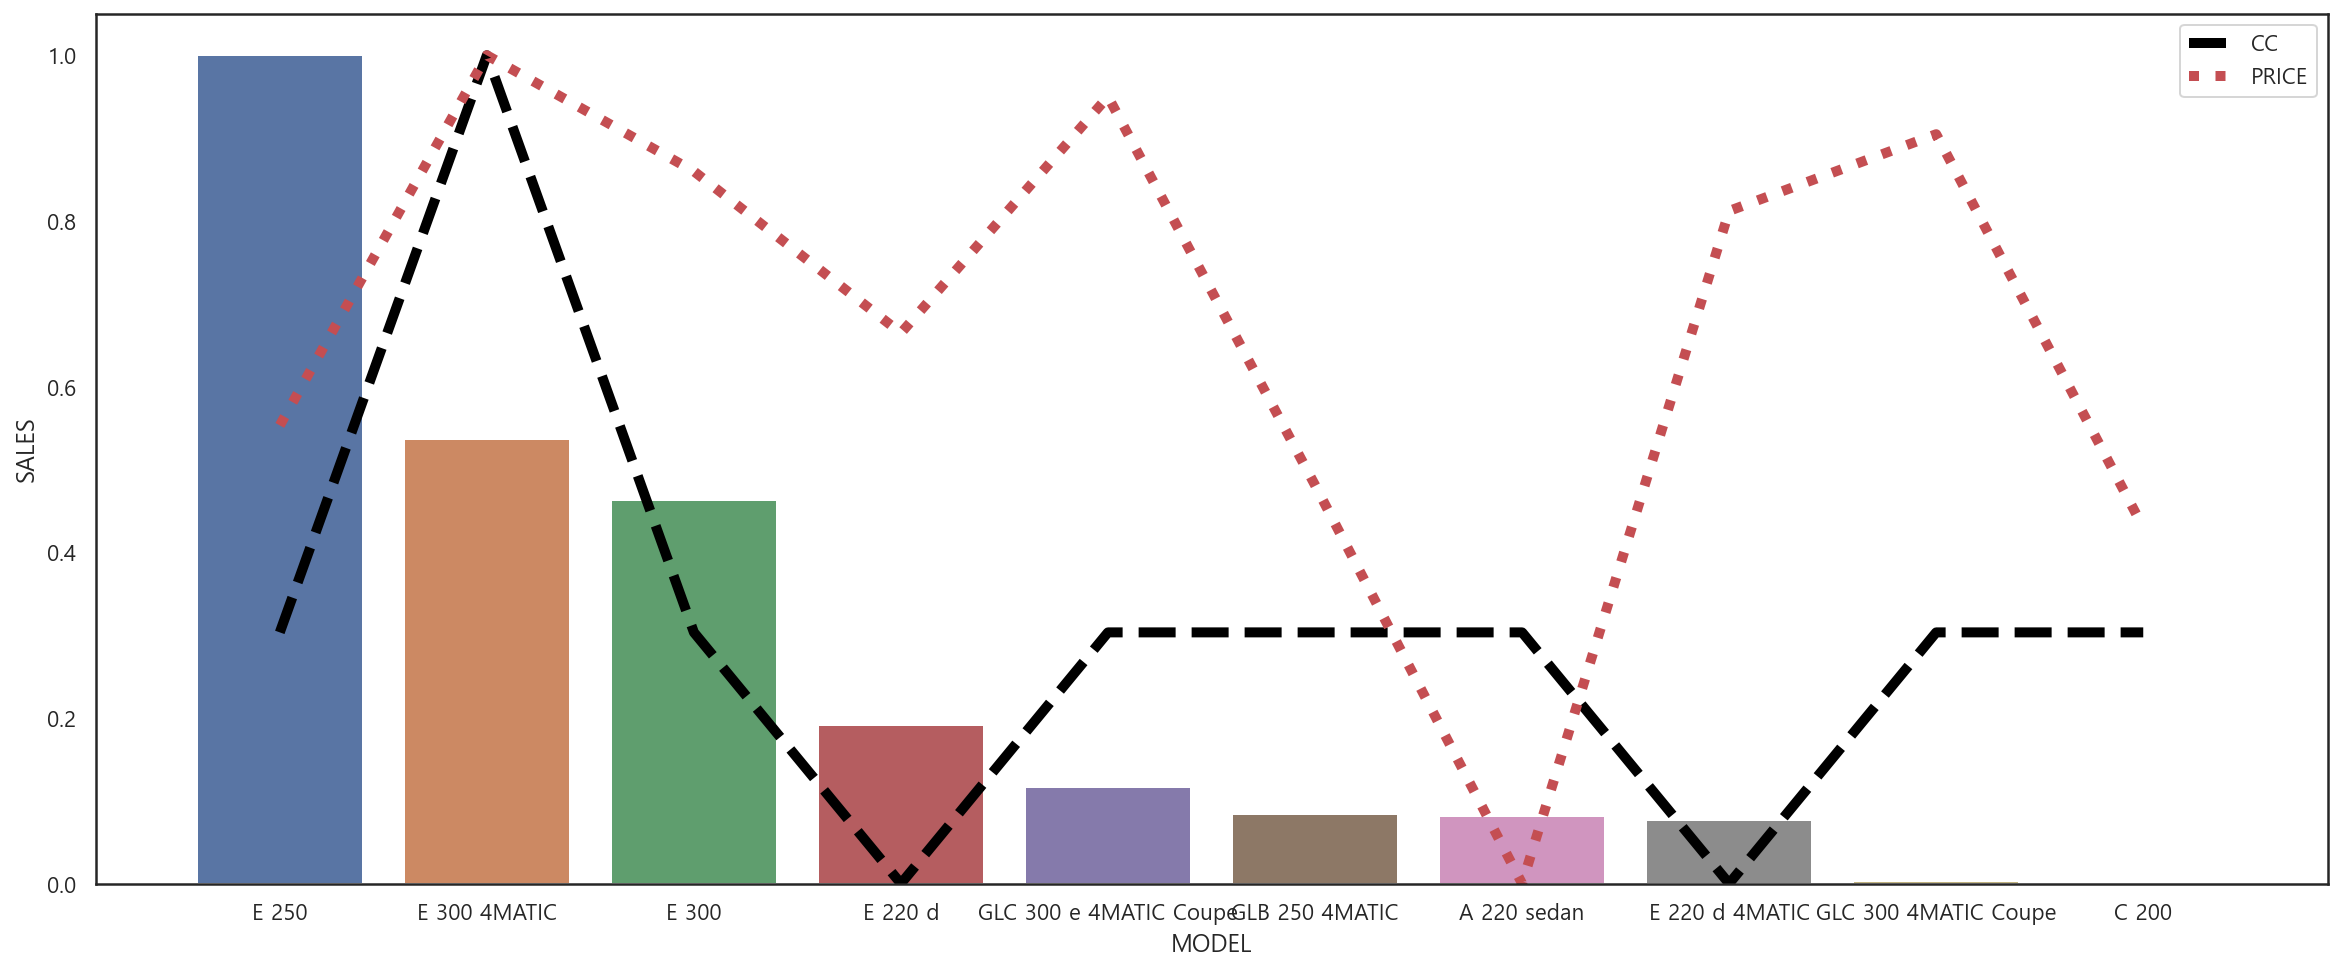

In [13]:
# fig, ax1 = plt.subplots
plt.figure(figsize=(20, 8))

ax1 = sns.barplot(data=mm_top_10, x=mm_top_10.index, y='SALES')
sns.lineplot(data=mm_top_10, x=mm_top_10.index, y="E-D(CC)",
             ax=ax1, label="CC", linewidth=5, color='black', linestyle='--')
sns.lineplot(data=mm_top_10, x=mm_top_10.index, y="PRICE",
             ax=ax1, label="PRICE", linewidth=5, color='r', linestyle=':')

plt.show()

- CC가 낮은데 가격이 높은 모델은 판매량이 적다

# 네이버 검색량 데이터

In [14]:
naver_df = pd.read_csv('datas/naver_query.csv')

naver_df['date'] = pd.to_datetime(naver_df['date'], format="%Y-%m-%d", errors='raise')
naver_df['day'] = naver_df['date'].dt.day
naver_df['season'] = naver_df['date'].dt.quarter

naver_df = naver_df[list(naver_df.columns[:3]) + list(naver_df.columns[-2:]) + list(naver_df.columns[3:-2])]
naver_df.set_index('date', inplace=True)
naver_df

,Year,Month,day,season,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2016,1,1,1,91367.5,36268.9,1014.9,50761.1,12804.6,11505.2,6687.9,5574.7,1400.5,13663.1,8501.1,5376.0,6199.5,40962.2,9505.0,605.4,12082.1,9170.2,954.6,15607.8,6558.9,348.1,33641.6
2016-01-02,2016,1,2,1,94927.9,39025.6,1132.1,52742.7,13012.0,11648.4,6821.0,6028.9,1585.1,14435.0,10611.9,6071.8,6576.9,41032.9,9338.6,644.8,9895.6,9670.6,1129.1,15573.4,6868.3,333.9,12209.4
2016-01-03,2016,1,3,1,93701.7,39610.2,1085.6,54485.8,13314.5,10978.5,6840.0,5785.8,1798.1,14423.9,8804.8,5763.7,6624.4,38500.1,10186.1,694.2,10135.7,9399.1,2208.8,13446.5,6681.6,358.1,5497.2
2016-01-04,2016,1,4,1,95439.2,41408.8,1344.9,58408.1,15052.8,10111.6,7061.0,6107.6,1726.4,14895.0,8963.2,5603.3,7024.9,38151.9,9838.0,1020.1,10775.0,9278.2,2094.8,13118.5,12713.8,420.7,4758.6
2016-01-05,2016,1,5,1,98758.3,39030.6,1233.0,60748.9,15571.0,9000.7,7668.6,5786.8,1571.1,15026.5,10219.7,5477.5,6304.4,34873.5,9477.7,1013.1,10625.1,8273.1,1518.6,12303.1,10076.1,360.2,2181.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,2021,5,1,2,164091.9,70336.3,1195.6,47125.7,12203.7,30242.1,9909.6,7358.6,1144.3,18412.5,8738.2,23721.5,2198.6,27571.9,14396.9,758.8,37879.4,16452.5,814.3,15004.4,3497.3,842.4,8034.0
2021-05-02,2021,5,2,2,179154.8,73506.8,1162.3,50218.2,13661.2,28573.2,8526.2,7161.8,1157.3,16845.3,8775.7,23859.9,2084.6,28642.7,14615.9,630.6,70863.2,16565.3,669.0,16080.0,3895.9,781.8,7525.4
2021-05-03,2021,5,3,2,158080.0,67748.3,1056.4,47557.8,11883.3,24529.9,8721.9,6611.9,1030.2,16364.0,9918.8,18800.5,2110.8,25819.4,12615.9,854.6,44034.6,15817.7,594.3,13335.5,3569.8,744.4,6143.0


#### 브랜드별 네이버 검색량 추이

In [15]:
# fig = px.line(naver_df, x=naver_df.index, y=naver_df.columns[4:])

# fig.update_layout(font_size=14, template="plotly_white")
# fig.update_annotations(font_size=19)
# fig.show()

### 연도별 브랜드의 쿼리

In [16]:
year_df = naver_df.groupby('Year').agg('mean').drop(columns=['Month', 'day', 'season']).round()
year_df

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
Year,,,,,,,,,,,,,,,,,,,,,,,
2016,112984.0,49839.0,1584.0,54968.0,15759.0,12037.0,8863.0,7114.0,2051.0,18029.0,11379.0,9533.0,8915.0,47975.0,12948.0,972.0,20660.0,10582.0,2143.0,20420.0,8806.0,1033.0,1731.0
2017,127130.0,54553.0,1414.0,43276.0,11018.0,11672.0,9896.0,8162.0,2155.0,20213.0,13605.0,13824.0,6815.0,56827.0,11333.0,988.0,26728.0,10754.0,1661.0,24106.0,5362.0,1023.0,1822.0
2018,126212.0,67914.0,1227.0,51201.0,14130.0,13058.0,10423.0,8755.0,2230.0,21408.0,12589.0,16351.0,6853.0,47862.0,11951.0,2491.0,29358.0,11083.0,712.0,20133.0,4732.0,787.0,2114.0
2019,124860.0,54021.0,1109.0,47016.0,9919.0,16421.0,8523.0,7210.0,2888.0,18620.0,10359.0,18739.0,5199.0,33758.0,13342.0,878.0,25984.0,12682.0,983.0,17905.0,3177.0,1250.0,6326.0
2020,142912.0,74251.0,1220.0,56073.0,15913.0,22992.0,6684.0,7222.0,2126.0,16032.0,9724.0,34030.0,3697.0,34687.0,14382.0,1000.0,30918.0,16457.0,1799.0,17638.0,5046.0,1110.0,6143.0
2021,156967.0,72335.0,1164.0,48994.0,16188.0,24687.0,7607.0,6937.0,1271.0,15816.0,9985.0,25678.0,2767.0,29707.0,14090.0,1435.0,27997.0,15381.0,625.0,14446.0,4611.0,927.0,5312.0


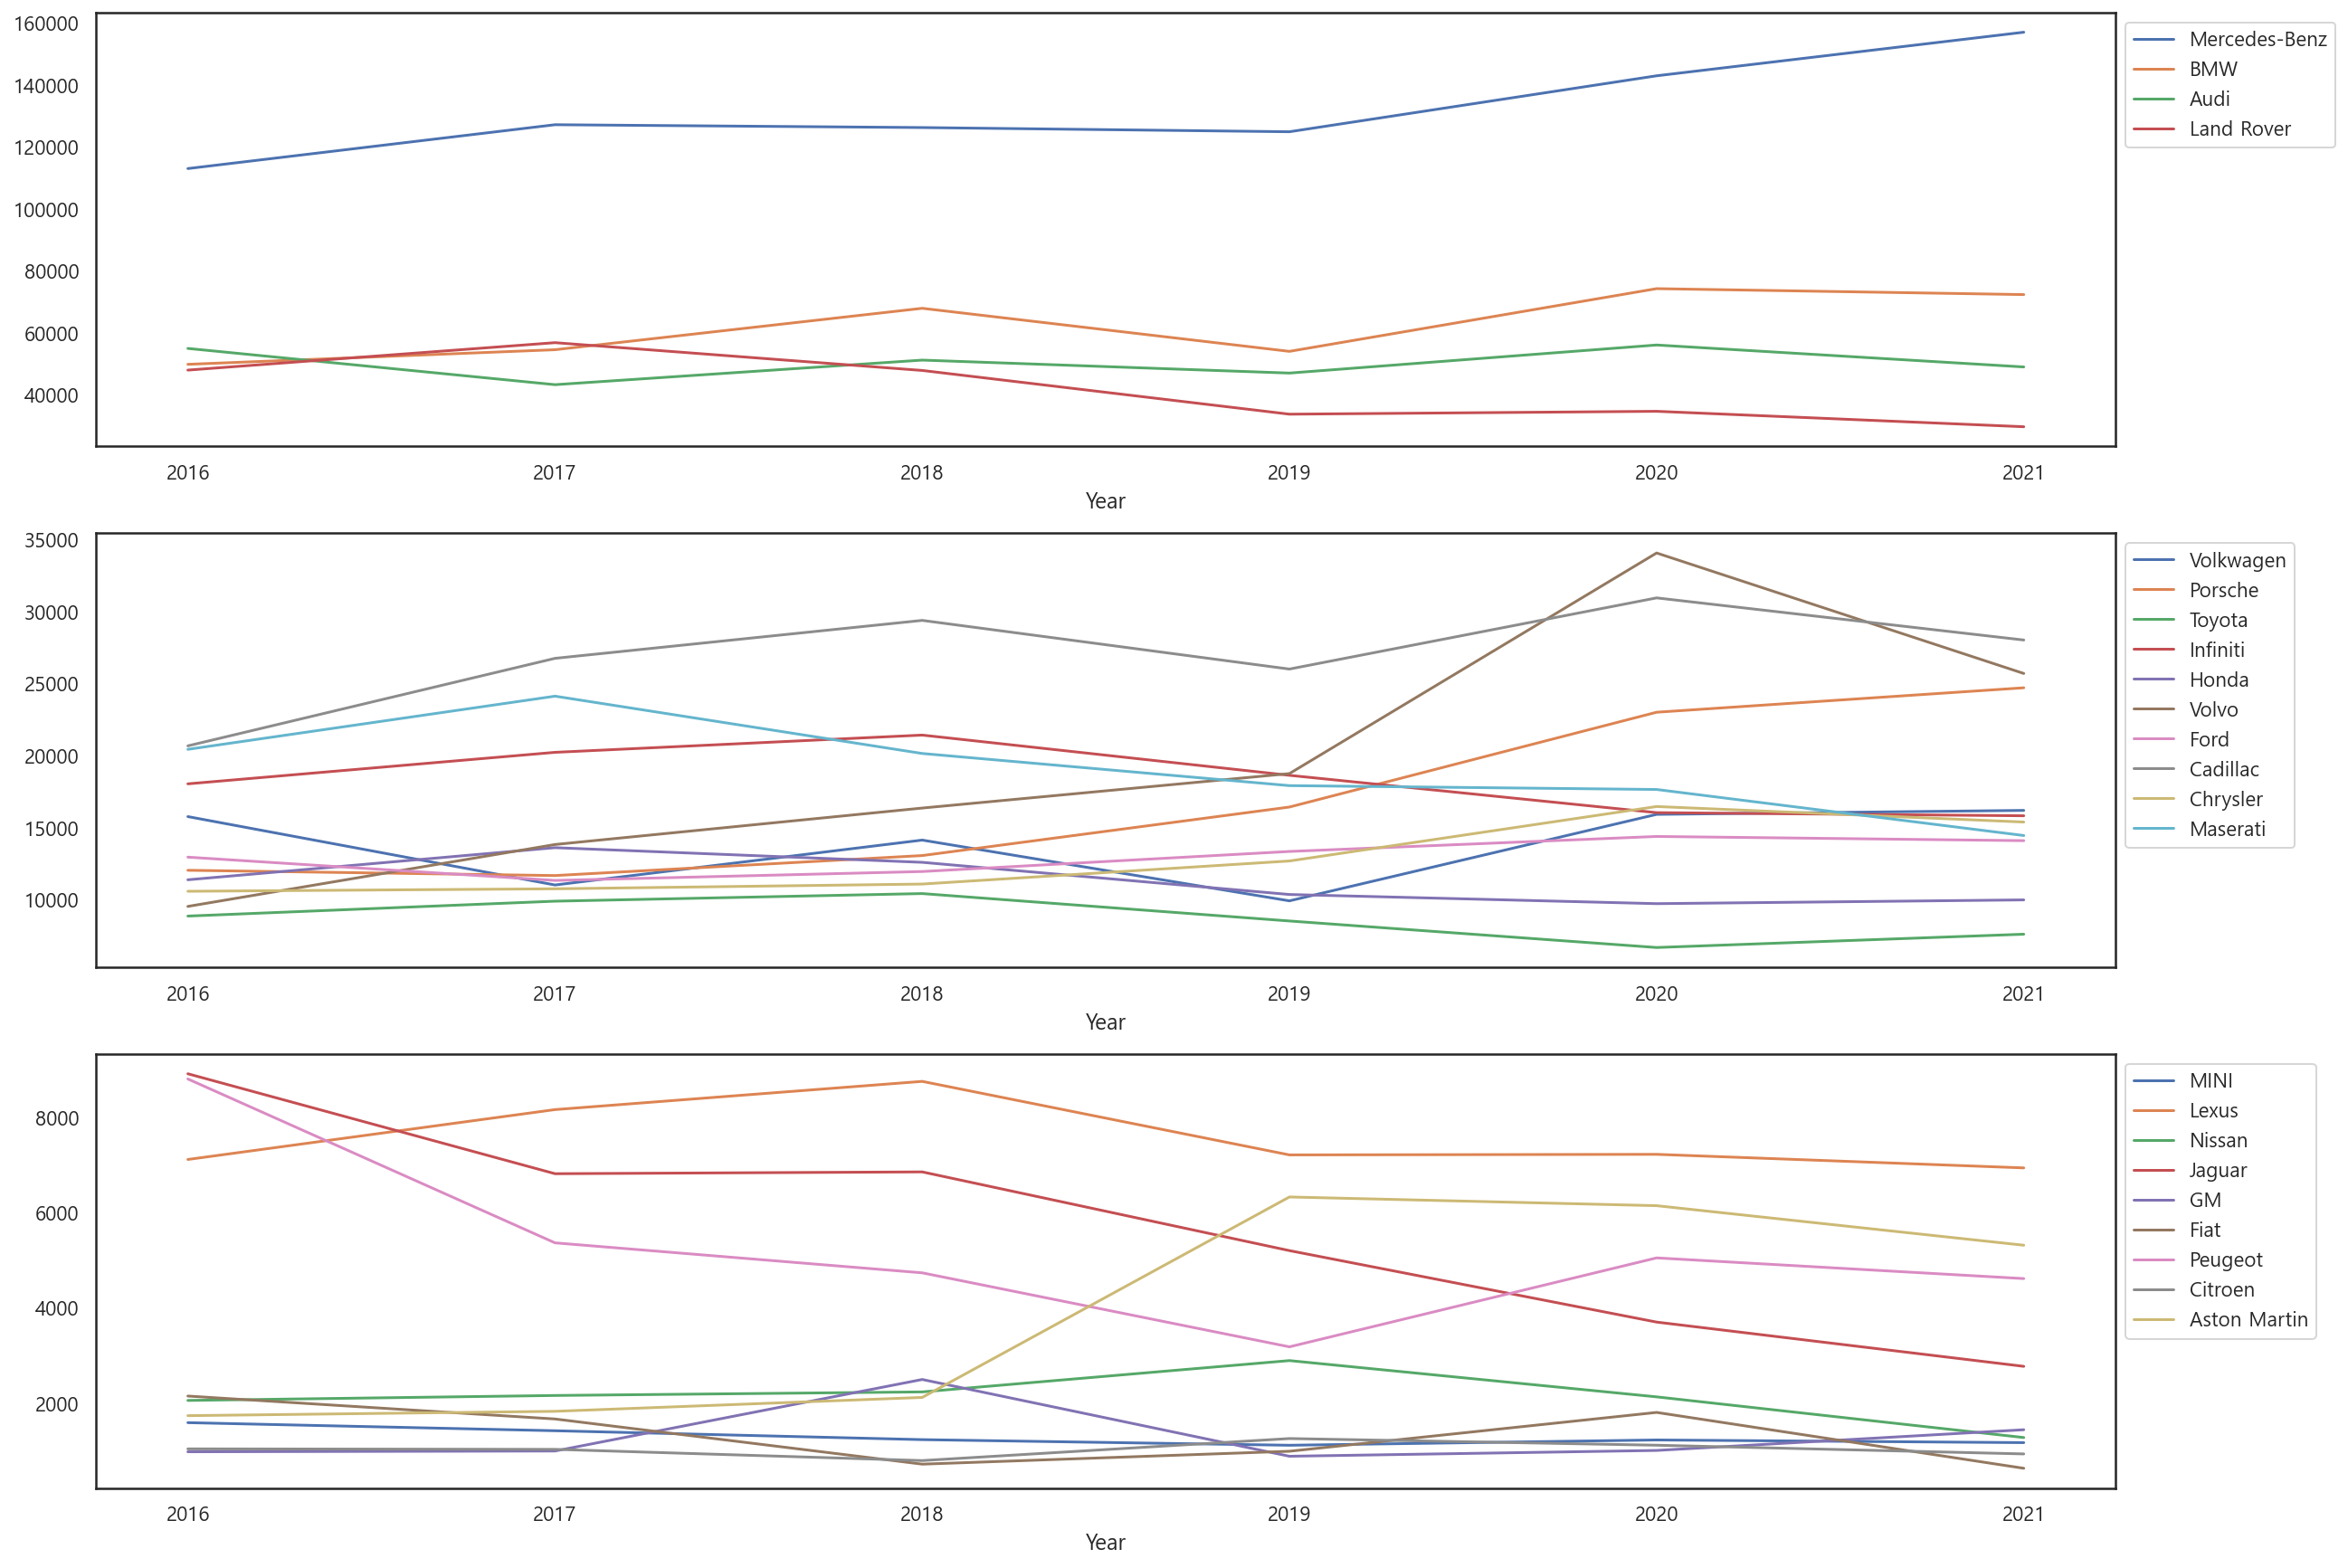

In [17]:
top = year_df.loc[:, np.all(year_df >= 29000, axis=0)]
bottom = year_df.loc[:, np.all(year_df < 10000, axis=0)]

middle_cols = list(set(year_df.columns) - set(top.columns) - set(bottom.columns))
middle = year_df[middle_cols]


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))

for col in year_df.columns:
    
    if col in top.columns:
        sns.lineplot(data=top, x=top.index, y=col, label=col, ax=ax1)
    elif col in middle.columns:
        sns.lineplot(data=middle, x=middle.index, y=col, label=col, ax=ax2)
    else:
        sns.lineplot(data=bottom, x=bottom.index, y=col, label=col, ax=ax3)

ax1.legend(bbox_to_anchor=(1.0, 1))
ax1.set_ylabel(None)
ax2.legend(bbox_to_anchor=(1.0, 1))
ax2.set_ylabel(None)
ax3.legend(bbox_to_anchor=(1.0, 1))
ax3.set_ylabel(None)
        
plt.show()

In [18]:
# model dataset 연도별 월평균판매량
df1 = model_data2[model_data2["BRAND"].isin(["Mercedes-Benz", "BMW"])][["BRAND", "YEAR", "AVG_SALES"]]

# query dataset 연도별 평균쿼리량
df2 = year_df.iloc[:, :2]

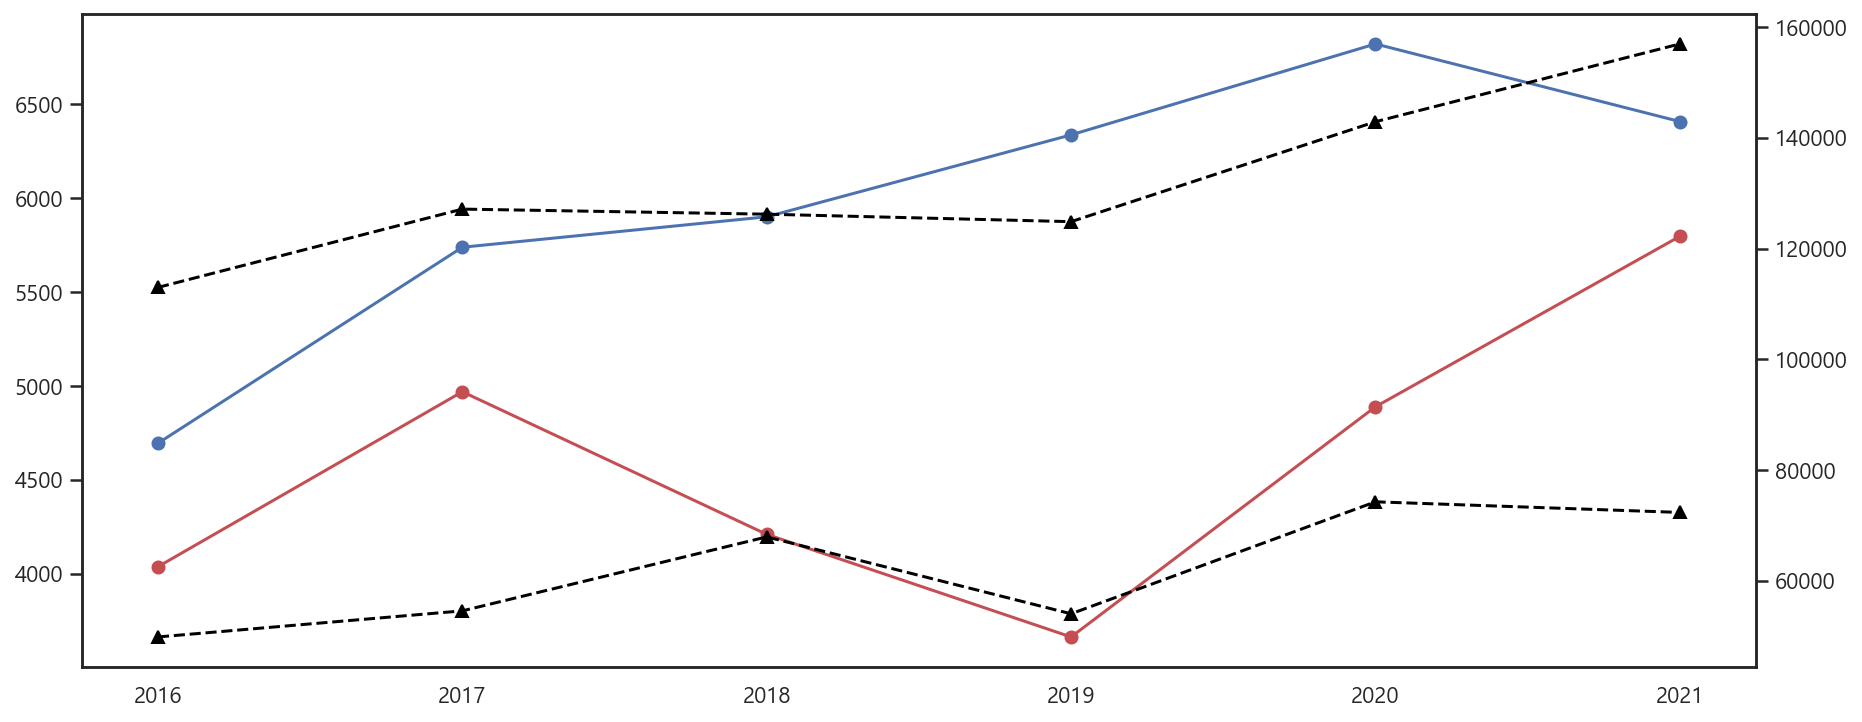

In [19]:
x = df2.index
y1 = df1[df1["BRAND"] == "Mercedes-Benz"]["AVG_SALES"]
y2 = df1[df1["BRAND"] == "BMW"]["AVG_SALES"]
y3 = df2.iloc[:, 0]
y4 = df2.iloc[:, 1]

fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

ax1.plot(x, y1, "bo-", label="Benz_sales")
ax1.plot(x, y2, "ro-", label="BMW_sales")
ax_tmp = ax1.twinx()
ax_tmp.plot(x, y3, "^--", color='black', label='Benz_query')
ax_tmp.plot(x, y4, "^--", color='black', label='BMW_query')


plt.show()

- 상위 두 브랜드의 연도별 네이버 검색량과 평균 판매량을 보았을 때 대체적으로 비례하는 것을 알 수 있다.

#### 전년동기대비 연도별 증감률(%)

In [20]:
year_percent = np.zeros((year_df.shape[0] - 1, year_df.shape[1]))
for num1 in range(year_df.shape[1]):
    for num2 in range(year_df.shape[0] - 1):
        year_percent[num2][num1] = ((year_df.values[num2+1][num1] - year_df.values[num2][num1]) / year_df.values[num2][num1]).round(2)
        

year_percent_df = pd.DataFrame(year_percent, columns=year_df.columns)
year_percent_df.index = [f"{15+num}-{16+num}" for num in range(1, 6)]
year_percent_df

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
16-17,0.13,0.09,-0.11,-0.21,-0.30,-0.03,0.12,0.15,0.05,0.12,0.20,0.45,-0.24,0.18,-0.12,0.02,0.29,0.02,-0.22,0.18,-0.39,-0.01,0.05
17-18,-0.01,0.24,-0.13,0.18,0.28,0.12,0.05,0.07,0.03,0.06,-0.07,0.18,0.01,-0.16,0.05,1.52,0.10,0.03,-0.57,-0.16,-0.12,-0.23,0.16
18-19,-0.01,-0.20,-0.10,-0.08,-0.30,0.26,-0.18,-0.18,0.30,-0.13,-0.18,0.15,-0.24,-0.29,0.12,-0.65,-0.11,0.14,0.38,-0.11,-0.33,0.59,1.99
19-20,0.14,0.37,0.10,0.19,0.60,0.40,-0.22,0.00,-0.26,-0.14,-0.06,0.82,-0.29,0.03,0.08,0.14,0.19,0.30,0.83,-0.01,0.59,-0.11,-0.03
20-21,0.10,-0.03,-0.05,-0.13,0.02,0.07,0.14,-0.04,-0.40,-0.01,0.03,-0.25,-0.25,-0.14,-0.02,0.44,-0.09,-0.07,-0.65,-0.18,-0.09,-0.16,-0.14


In [21]:
year_percent_brand = year_percent_df.T
year_percent_brand['total'] = np.sum(year_percent_brand, axis=1).round(2)
year_percent_brand.sort_values('total', ascending=False, inplace=True)
year_percent_brand.head(10)

,16-17,17-18,18-19,19-20,20-21,total
Aston Martin,0.05,0.16,1.99,-0.03,-0.14,2.03
GM,0.02,1.52,-0.65,0.14,0.44,1.47
Volvo,0.45,0.18,0.15,0.82,-0.25,1.35
Porsche,-0.03,0.12,0.26,0.40,0.07,0.82
BMW,0.09,0.24,-0.20,0.37,-0.03,0.47
Chrysler,0.02,0.03,0.14,0.30,-0.07,0.42
Cadillac,0.29,0.10,-0.11,0.19,-0.09,0.38
Mercedes-Benz,0.13,-0.01,-0.01,0.14,0.10,0.35
Volkwagen,-0.30,0.28,-0.30,0.60,0.02,0.30
Ford,-0.12,0.05,0.12,0.08,-0.02,0.11


0.20217391304347823


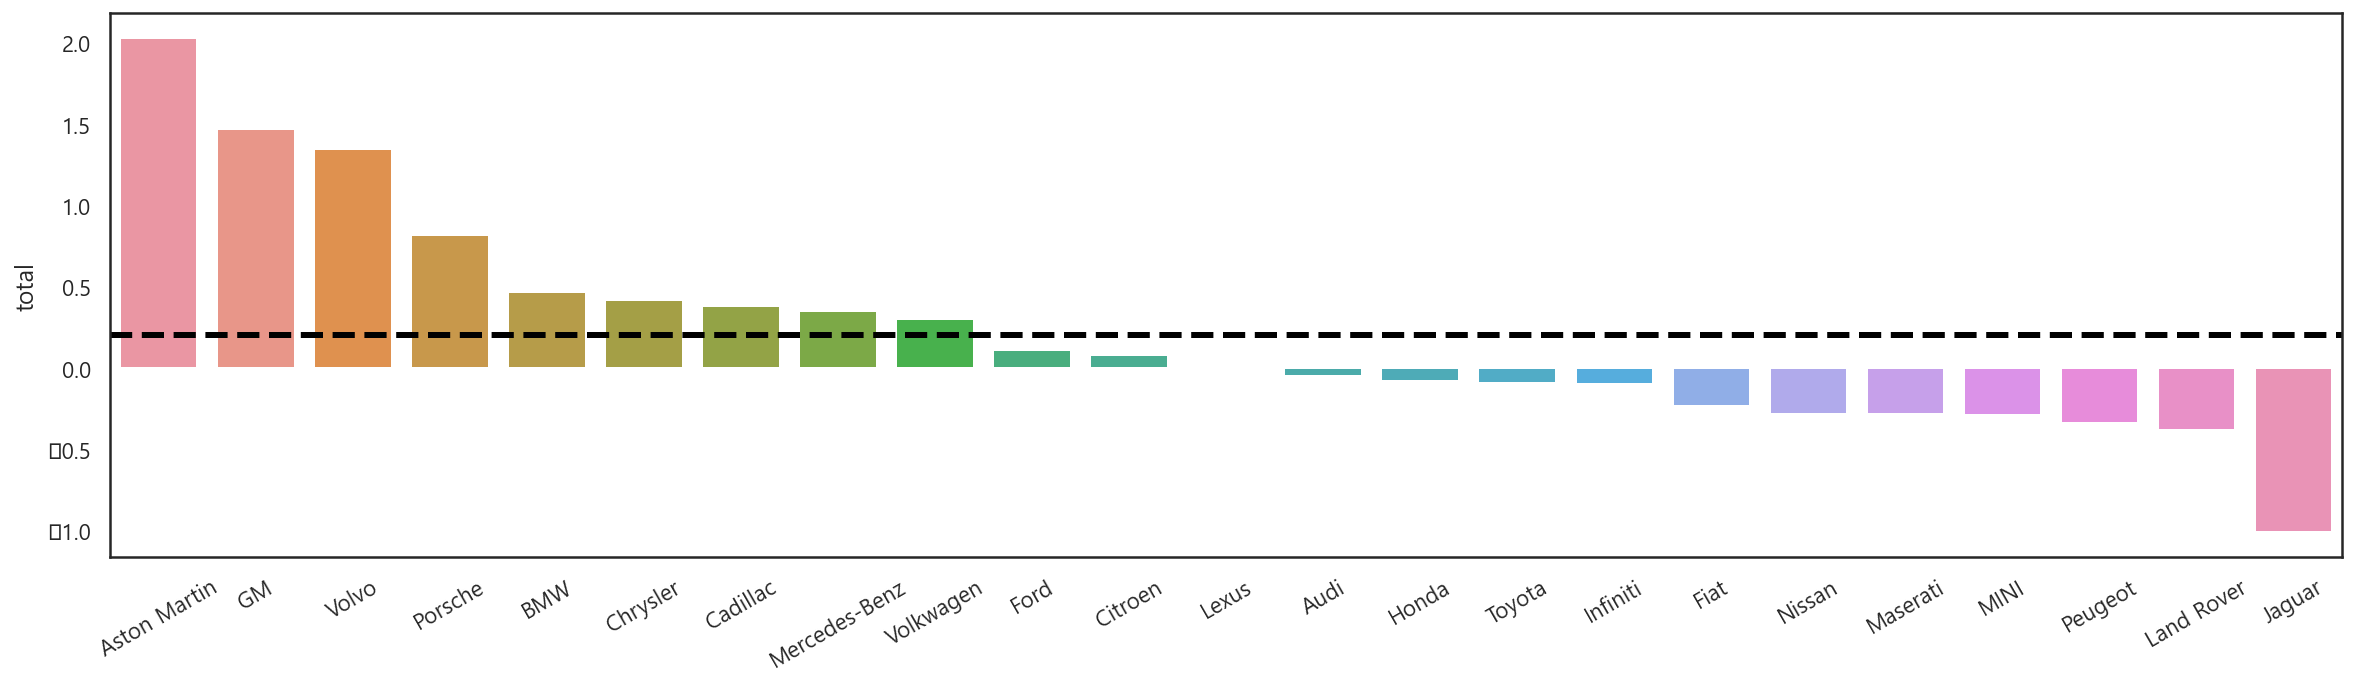

In [22]:
print(np.mean(year_percent_brand, axis=0)[-1])

plt.figure(figsize=(20, 5))

sns.barplot(data=year_percent_brand, x=year_percent_brand.index, y='total')
plt.axhline(np.mean(year_percent_brand, axis=0)[-1],
            color='black', linestyle='--', linewidth=3)

plt.xticks(rotation=30)
plt.show()

- 16 ~ 21간 평균쿼리증감률 0.2보다 높은 증가율은 보인 브랜드
    - Aston Martin, GM, Volvo, Porsche, BMW, Chrysler, Cadillac, Mercedes-Benz

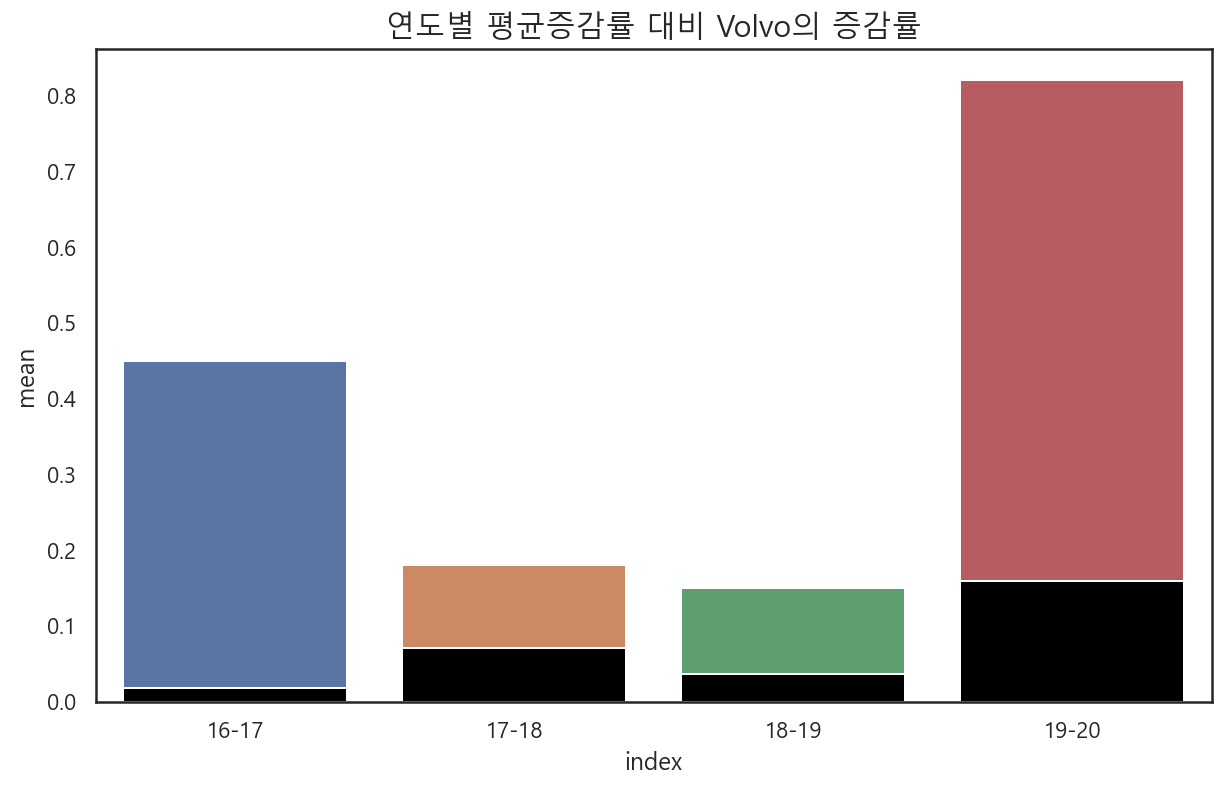

In [23]:
volvo = year_percent_df['Volvo'][:-1].reset_index()
total_mean = np.mean(year_percent_brand, axis=0).reset_index(name='mean')[:-2]

plt.figure(figsize=(10, 6))

sns.barplot(data=volvo, x='index', y='Volvo')
sns.barplot(data=total_mean, x='index', y='mean', color='black')
plt.title('연도별 평균증감률 대비 Volvo의 증감률', fontsize=15)

plt.show()

- total 전년동기대비 증감율보다 항상 높은 증감율을 보여줬던 브랜드는 Volvo가 유일하다.
    - 2021년 제외

### 월별 브랜드의 쿼리

In [24]:
month_df = naver_df.groupby('Month').mean().iloc[:, 3:].round()
month_df

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
Month,,,,,,,,,,,,,,,,,,,,,,,
1,124467.0,55949.0,1189.0,47566.0,13103.0,14233.0,8833.0,7294.0,2213.0,18340.0,11155.0,14496.0,5362.0,40807.0,13540.0,1099.0,23810.0,11046.0,2129.0,19419.0,5688.0,1157.0,7663.0
2,133376.0,59207.0,1240.0,49310.0,13973.0,15329.0,9078.0,7726.0,2193.0,18998.0,11616.0,16412.0,6280.0,43194.0,13402.0,2255.0,25379.0,11386.0,2190.0,18970.0,6157.0,1064.0,4406.0
3,127601.0,58146.0,1291.0,49929.0,12612.0,17831.0,9755.0,7258.0,2178.0,19191.0,11025.0,15863.0,6793.0,42807.0,11914.0,1598.0,25791.0,12988.0,1859.0,17799.0,5697.0,989.0,3090.0
4,128176.0,56509.0,1473.0,47745.0,12316.0,16241.0,8559.0,7063.0,1996.0,17618.0,10573.0,14424.0,5682.0,39216.0,11561.0,1984.0,25344.0,12197.0,1573.0,17570.0,4851.0,928.0,3244.0
5,126349.0,56079.0,1422.0,50234.0,11460.0,14754.0,8803.0,7595.0,2704.0,19102.0,11177.0,14213.0,6014.0,41512.0,11734.0,1062.0,27455.0,11387.0,1476.0,17994.0,4705.0,931.0,2949.0
6,125082.0,56838.0,1437.0,49849.0,11844.0,16486.0,8836.0,7875.0,2753.0,19465.0,14607.0,16831.0,6843.0,45765.0,12075.0,923.0,28160.0,12107.0,1268.0,21987.0,5525.0,965.0,3296.0
7,127377.0,67541.0,1339.0,58249.0,15513.0,15947.0,8191.0,8021.0,2163.0,18375.0,11670.0,36856.0,6601.0,45940.0,13340.0,906.0,31730.0,12539.0,1151.0,22601.0,5140.0,878.0,3642.0
8,135809.0,91041.0,1289.0,51039.0,16769.0,16442.0,8800.0,8492.0,2038.0,19331.0,11193.0,27472.0,6246.0,50634.0,13797.0,873.0,32310.0,13023.0,1104.0,22006.0,5624.0,1145.0,3896.0
9,133502.0,59774.0,1334.0,51437.0,11203.0,19264.0,7989.0,7888.0,2187.0,18064.0,11049.0,22406.0,5927.0,51332.0,14541.0,1160.0,29426.0,14058.0,1099.0,19255.0,5877.0,1363.0,3315.0


In [25]:
fig = go.Figure()

for i in range(len(month_df.columns)):
    fig.add_trace(
        go.Bar(name=month_df.columns[i], y=month_df.iloc[:,i], x=month_df.index))

# fig.update_layout(barmode='stack')
# fig.show()

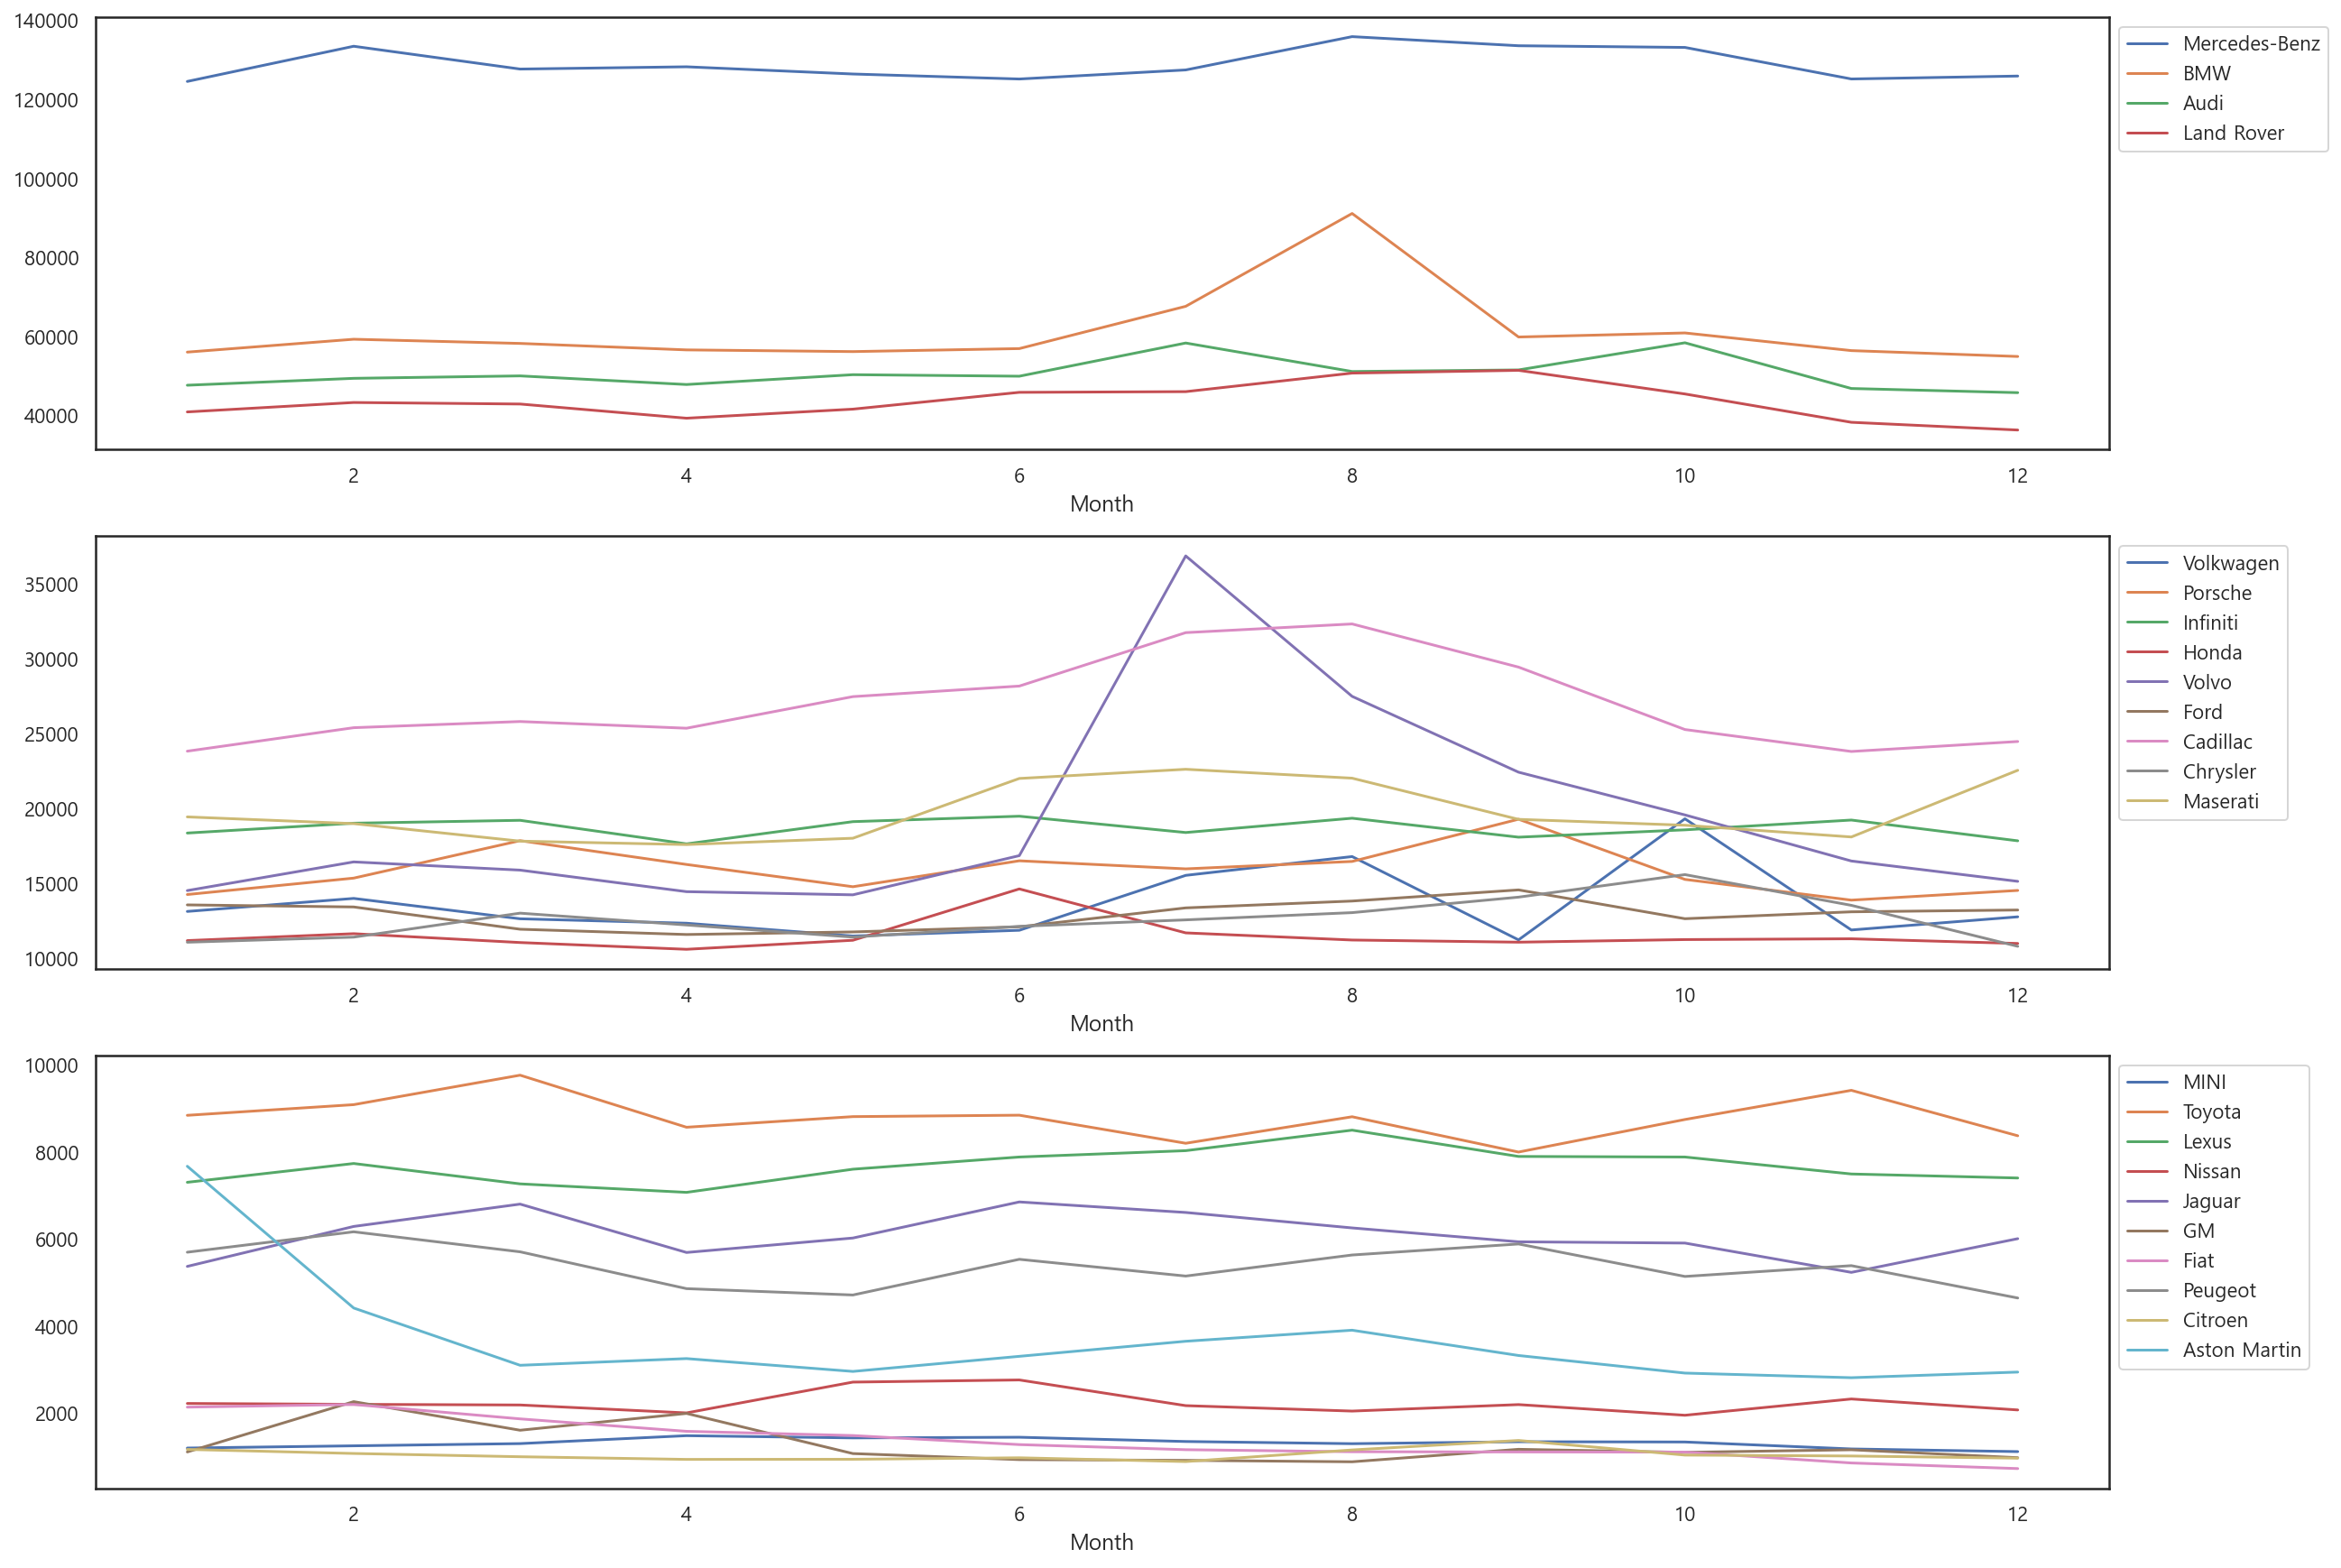

In [26]:
top = month_df.loc[: , np.any(month_df >= 40000, axis=0)]
middle = month_df.loc[: , np.any((month_df < 40000) & (month_df > 10000), axis=0)]

bottom_ls = set(month_df.columns) - set(top.columns) - set(middle.columns)
bottom = month_df[bottom_ls]


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))

for col in month_df.columns:
    
    if col in top.columns:
        sns.lineplot(data=top, x=top.index, y=col, label=col, ax=ax1)
    elif col in middle.columns:
        sns.lineplot(data=middle, x=middle.index, y=col, label=col, ax=ax2)
    else:
        sns.lineplot(data=bottom, x=bottom.index, y=col, label=col, ax=ax3)

ax1.legend(bbox_to_anchor=(1.0, 1))
ax1.set_ylabel(None)
ax2.legend(bbox_to_anchor=(1.0, 1))
ax2.set_ylabel(None)
ax3.legend(bbox_to_anchor=(1.0, 1))
ax3.set_ylabel(None)
        
plt.show()

#### 전년동기대비 월별 증감률(%)

In [27]:
month_percent = np.zeros((month_df.shape[0] - 1, month_df.shape[1]))
for num1 in range(month_df.shape[1]):
    for num2 in range(month_df.shape[0] - 1):
        month_percent[num2][num1] = ((month_df.values[num2+1][num1] - month_df.values[num2][num1]) / month_df.values[num2][num1]).round(2)

In [28]:
month_percent_df = pd.DataFrame(month_percent, columns=month_df.columns)
month_percent_df.index = [f"{0+num}-{1+num}" for num in range(1, 12)]
month_percent_df

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
1-2,0.07,0.06,0.04,0.04,0.07,0.08,0.03,0.06,-0.01,0.04,0.04,0.13,0.17,0.06,-0.01,1.05,0.07,0.03,0.03,-0.02,0.08,-0.08,-0.43
2-3,-0.04,-0.02,0.04,0.01,-0.10,0.16,0.07,-0.06,-0.01,0.01,-0.05,-0.03,0.08,-0.01,-0.11,-0.29,0.02,0.14,-0.15,-0.06,-0.07,-0.07,-0.30
3-4,0.00,-0.03,0.14,-0.04,-0.02,-0.09,-0.12,-0.03,-0.08,-0.08,-0.04,-0.09,-0.16,-0.08,-0.03,0.24,-0.02,-0.06,-0.15,-0.01,-0.15,-0.06,0.05
4-5,-0.01,-0.01,-0.03,0.05,-0.07,-0.09,0.03,0.08,0.35,0.08,0.06,-0.01,0.06,0.06,0.01,-0.46,0.08,-0.07,-0.06,0.02,-0.03,0.00,-0.09
5-6,-0.01,0.01,0.01,-0.01,0.03,0.12,0.00,0.04,0.02,0.02,0.31,0.18,0.14,0.10,0.03,-0.13,0.03,0.06,-0.14,0.22,0.17,0.04,0.12
6-7,0.02,0.19,-0.07,0.17,0.31,-0.03,-0.07,0.02,-0.21,-0.06,-0.20,1.19,-0.04,0.00,0.10,-0.02,0.13,0.04,-0.09,0.03,-0.07,-0.09,0.10
7-8,0.07,0.35,-0.04,-0.12,0.08,0.03,0.07,0.06,-0.06,0.05,-0.04,-0.25,-0.05,0.10,0.03,-0.04,0.02,0.04,-0.04,-0.03,0.09,0.30,0.07
8-9,-0.02,-0.34,0.03,0.01,-0.33,0.17,-0.09,-0.07,0.07,-0.07,-0.01,-0.18,-0.05,0.01,0.05,0.33,-0.09,0.08,-0.00,-0.13,0.04,0.19,-0.15
9-10,-0.00,0.02,-0.00,0.13,0.72,-0.21,0.09,-0.00,-0.11,0.03,0.02,-0.13,-0.00,-0.12,-0.13,-0.06,-0.14,0.11,-0.00,-0.02,-0.13,-0.25,-0.12
10-11,-0.06,-0.07,-0.12,-0.20,-0.39,-0.09,0.08,-0.05,0.19,0.04,0.00,-0.16,-0.11,-0.16,0.04,0.05,-0.06,-0.13,-0.23,-0.04,0.05,-0.02,-0.04


In [29]:
month_percent_brand = month_percent_df.T
month_percent_brand.loc['total'] = np.mean(month_percent_brand, axis=0).round(2)
month_percent_brand

,1-2,2-3,3-4,4-5,5-6,6-7,7-8,8-9,9-10,10-11,11-12
Mercedes-Benz,0.07,-0.04,0.00,-0.01,-0.01,0.02,0.07,-0.02,-0.00,-0.06,0.01
BMW,0.06,-0.02,-0.03,-0.01,0.01,0.19,0.35,-0.34,0.02,-0.07,-0.03
MINI,0.04,0.04,0.14,-0.03,0.01,-0.07,-0.04,0.03,-0.00,-0.12,-0.05
Audi,0.04,0.01,-0.04,0.05,-0.01,0.17,-0.12,0.01,0.13,-0.20,-0.02
Volkwagen,0.07,-0.10,-0.02,-0.07,0.03,0.31,0.08,-0.33,0.72,-0.39,0.07
Porsche,0.08,0.16,-0.09,-0.09,0.12,-0.03,0.03,0.17,-0.21,-0.09,0.05
Toyota,0.03,0.07,-0.12,0.03,0.00,-0.07,0.07,-0.09,0.09,0.08,-0.11
Lexus,0.06,-0.06,-0.03,0.08,0.04,0.02,0.06,-0.07,-0.00,-0.05,-0.01
Nissan,-0.01,-0.01,-0.08,0.35,0.02,-0.21,-0.06,0.07,-0.11,0.19,-0.11
Infiniti,0.04,0.01,-0.08,0.08,0.02,-0.06,0.05,-0.07,0.03,0.04,-0.07


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

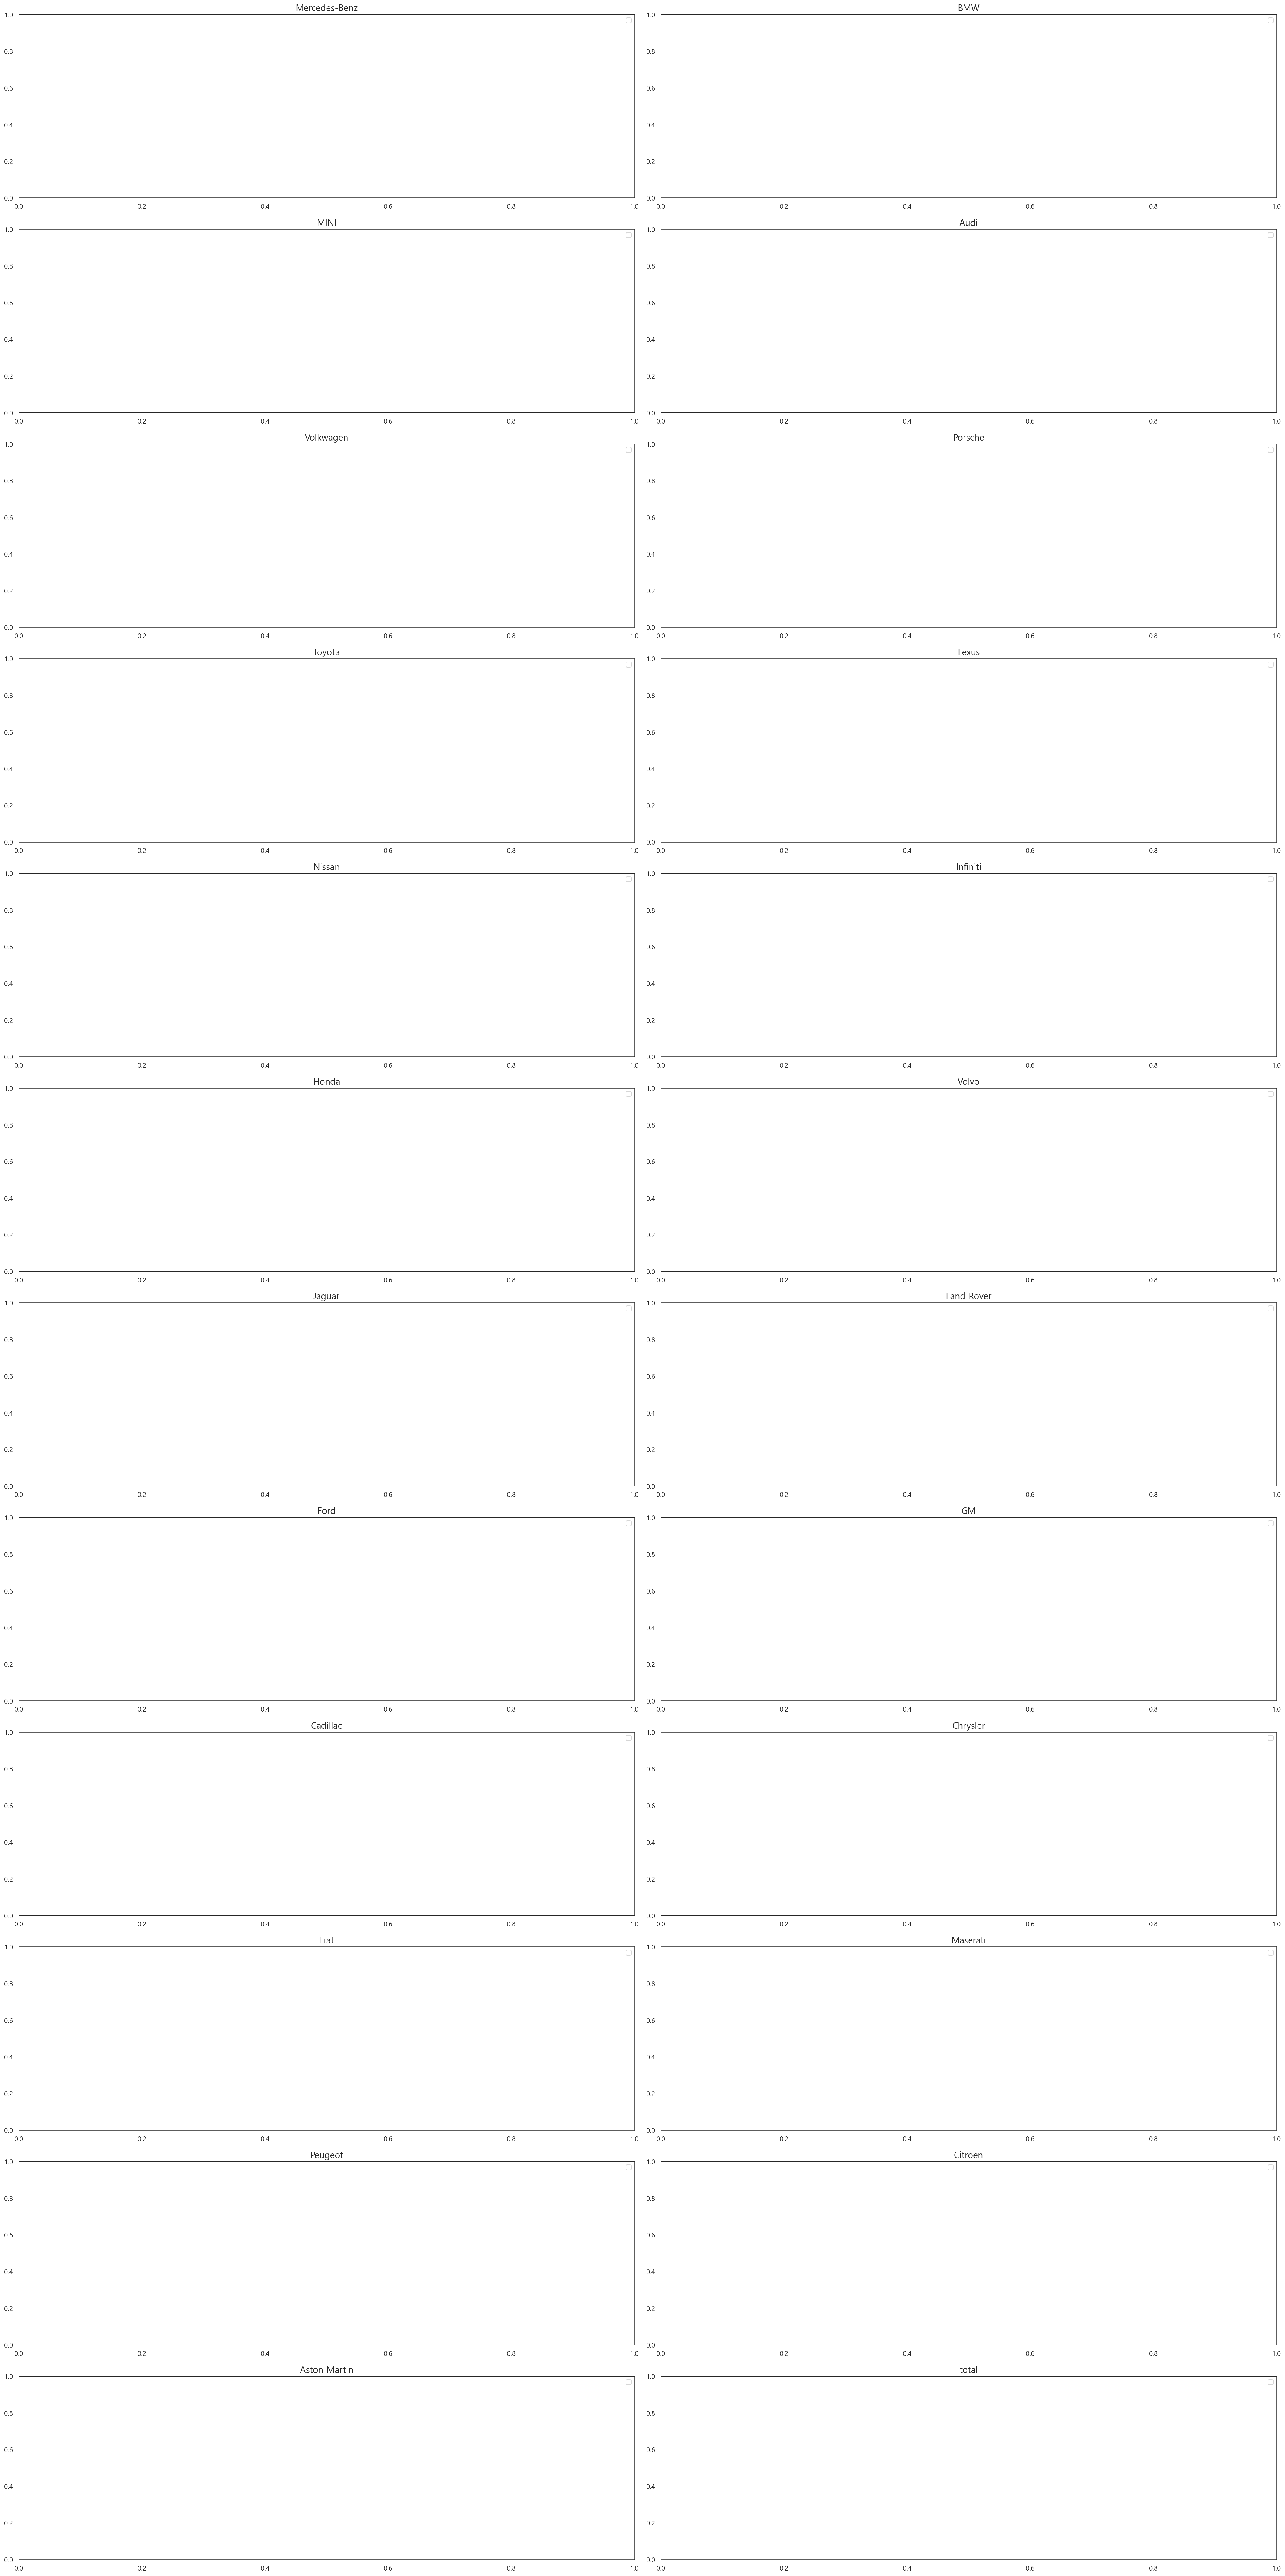

In [30]:
plt.figure(figsize=(30, 60))

for idx, index in enumerate(month_percent_brand.index):
    plt.subplot(month_percent_brand.shape[0] / 2, 2, idx+1)
    month_percent_brand.loc[index].plot.line()
    month_percent_brand.loc['total'].plot.line()
    plt.title(index, fontsize=15)
    plt.legend()
    
plt.tight_layout()
plt.show()

### 전월대비 쿼리 증감률

In [31]:
# year_month_df
test = naver_df.groupby(['Year', 'Month']).mean()
test = test.reset_index()
test

,Year,Month,day,season,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
0,2016,1,16.0,1.0,98930.109677,42485.383871,1225.070968,52778.635484,13729.832258,9998.083871,8256.380645,6170.541935,1701.554839,16128.477419,8572.664516,7331.503226,7671.422581,37998.490323,14197.367742,858.154839,13578.516129,9920.361290,1185.680645,12011.241935,10372.154839,519.312903,3874.580645
1,2016,2,15.0,1.0,113042.558621,48693.744828,1365.962069,55282.444828,16810.620690,10367.168966,8593.444828,7148.513793,2084.679310,17826.637931,10381.403448,8723.568966,10196.979310,41888.989655,14966.151724,817.172414,17336.562069,10388.431034,1208.824138,14251.344828,11109.003448,459.613793,1814.103448
2,2016,3,16.0,1.0,107213.270968,52370.116129,1445.758065,61762.293548,16121.648387,9698.474194,8988.293548,5828.029032,1900.106452,16716.429032,10049.677419,8963.841935,12878.835484,43223.319355,11323.180645,900.503226,14253.645161,9968.787097,4988.419355,15966.980645,10320.083871,547.232258,1770.167742
3,2016,4,15.5,2.0,108475.126667,47473.166667,2216.866667,60215.823333,15391.470000,11999.870000,8301.256667,5737.220000,2023.553333,16062.030000,9174.563333,10645.303333,8478.616667,40764.700000,9892.370000,1470.840000,16003.523333,10808.246667,3861.370000,14467.143333,8754.746667,571.513333,1440.206667
4,2016,5,16.0,2.0,109536.132258,48915.151613,1678.677419,75796.141935,13704.403226,11115.000000,7689.925806,5615.903226,2394.587097,15700.416129,9090.122581,9894.880645,7328.283871,42962.309677,11628.032258,1206.116129,14295.432258,10045.377419,2112.700000,17011.825806,7780.912903,494.651613,1341.864516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,2021,1,16.0,1.0,146657.961290,72735.829032,1039.635484,46809.919355,19800.854839,20299.538710,6794.919355,6841.900000,1321.361290,14958.180645,10474.377419,28850.470968,3004.680645,28423.538710,14436.503226,2083.745161,25141.893548,14373.832258,631.451613,15760.338710,4686.300000,958.545161,4925.103226
61,2021,2,14.5,1.0,166443.457143,78122.075000,1250.567857,53998.489286,16750.628571,22656.975000,7521.314286,7316.317857,1575.653571,16413.285714,10897.050000,29318.628571,2833.507143,32851.125000,14346.646429,1524.646429,27899.453571,14246.475000,603.353571,15029.703571,4405.239286,1027.032143,5268.564286
62,2021,3,16.0,1.0,153522.225806,69336.929032,1181.735484,49311.567742,15815.748387,31744.583871,8028.945161,6860.216129,1129.961290,16019.122581,9385.619355,23042.945161,2951.609677,30723.380645,13502.193548,1181.383871,28196.016129,16485.254839,637.667742,13463.877419,5364.306452,858.883871,5088.045161
63,2021,4,15.5,2.0,161510.903333,70115.106667,1203.960000,46519.480000,12956.080000,23418.306667,7896.593333,6743.286667,1106.440000,15746.320000,9360.920000,22465.513333,2368.343333,27445.910000,14101.760000,1048.183333,27985.803333,16218.263333,616.740000,13599.263333,4092.070000,896.463333,5716.146667


In [32]:
test['date'] = test['Year'].astype(str) + "-" + test['Month'].astype(str)
test = test[list([test.columns[-1]]) + list(test.columns[4:-1])]
test.set_index('date', inplace=True)
test

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
date,,,,,,,,,,,,,,,,,,,,,,,
2016-1,98930.109677,42485.383871,1225.070968,52778.635484,13729.832258,9998.083871,8256.380645,6170.541935,1701.554839,16128.477419,8572.664516,7331.503226,7671.422581,37998.490323,14197.367742,858.154839,13578.516129,9920.361290,1185.680645,12011.241935,10372.154839,519.312903,3874.580645
2016-2,113042.558621,48693.744828,1365.962069,55282.444828,16810.620690,10367.168966,8593.444828,7148.513793,2084.679310,17826.637931,10381.403448,8723.568966,10196.979310,41888.989655,14966.151724,817.172414,17336.562069,10388.431034,1208.824138,14251.344828,11109.003448,459.613793,1814.103448
2016-3,107213.270968,52370.116129,1445.758065,61762.293548,16121.648387,9698.474194,8988.293548,5828.029032,1900.106452,16716.429032,10049.677419,8963.841935,12878.835484,43223.319355,11323.180645,900.503226,14253.645161,9968.787097,4988.419355,15966.980645,10320.083871,547.232258,1770.167742
2016-4,108475.126667,47473.166667,2216.866667,60215.823333,15391.470000,11999.870000,8301.256667,5737.220000,2023.553333,16062.030000,9174.563333,10645.303333,8478.616667,40764.700000,9892.370000,1470.840000,16003.523333,10808.246667,3861.370000,14467.143333,8754.746667,571.513333,1440.206667
2016-5,109536.132258,48915.151613,1678.677419,75796.141935,13704.403226,11115.000000,7689.925806,5615.903226,2394.587097,15700.416129,9090.122581,9894.880645,7328.283871,42962.309677,11628.032258,1206.116129,14295.432258,10045.377419,2112.700000,17011.825806,7780.912903,494.651613,1341.864516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-1,146657.961290,72735.829032,1039.635484,46809.919355,19800.854839,20299.538710,6794.919355,6841.900000,1321.361290,14958.180645,10474.377419,28850.470968,3004.680645,28423.538710,14436.503226,2083.745161,25141.893548,14373.832258,631.451613,15760.338710,4686.300000,958.545161,4925.103226
2021-2,166443.457143,78122.075000,1250.567857,53998.489286,16750.628571,22656.975000,7521.314286,7316.317857,1575.653571,16413.285714,10897.050000,29318.628571,2833.507143,32851.125000,14346.646429,1524.646429,27899.453571,14246.475000,603.353571,15029.703571,4405.239286,1027.032143,5268.564286
2021-3,153522.225806,69336.929032,1181.735484,49311.567742,15815.748387,31744.583871,8028.945161,6860.216129,1129.961290,16019.122581,9385.619355,23042.945161,2951.609677,30723.380645,13502.193548,1181.383871,28196.016129,16485.254839,637.667742,13463.877419,5364.306452,858.883871,5088.045161


In [33]:
test_percent = np.zeros((test.shape[0] - 1, test.shape[1]))
for num1 in range(test.shape[1]):
    for num2 in range(test.shape[0] - 1):
        test_percent[num2][num1] = ((test.values[num2+1][num1] - test.values[num2][num1]) / test.values[num2][num1]).round(2)

In [34]:
test_percent_df = pd.DataFrame(test_percent, columns=test.columns)
test_percent_df

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
0,0.14,0.15,0.12,0.05,0.22,0.04,0.04,0.16,0.23,0.11,0.21,0.19,0.33,0.10,0.05,-0.05,0.28,0.05,0.02,0.19,0.07,-0.11,-0.53
1,-0.05,0.08,0.06,0.12,-0.04,-0.06,0.05,-0.18,-0.09,-0.06,-0.03,0.03,0.26,0.03,-0.24,0.10,-0.18,-0.04,3.13,0.12,-0.07,0.19,-0.02
2,0.01,-0.09,0.53,-0.03,-0.05,0.24,-0.08,-0.02,0.06,-0.04,-0.09,0.19,-0.34,-0.06,-0.13,0.63,0.12,0.08,-0.23,-0.09,-0.15,0.04,-0.19
3,0.01,0.03,-0.24,0.26,-0.11,-0.07,-0.07,-0.02,0.18,-0.02,-0.01,-0.07,-0.14,0.05,0.18,-0.18,-0.11,-0.07,-0.45,0.18,-0.11,-0.13,-0.07
4,-0.03,0.01,0.08,-0.20,0.17,0.23,0.12,0.30,-0.19,0.14,0.07,-0.02,0.33,0.10,-0.04,-0.08,0.19,0.03,-0.06,0.29,0.11,0.04,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.07,-0.05,-0.05,-0.15,-0.12,0.04,0.01,0.00,0.06,0.01,0.10,0.08,-0.23,0.01,0.07,1.03,-0.18,0.04,0.24,0.10,-0.25,0.11,-0.12
60,0.13,0.07,0.20,0.15,-0.15,0.12,0.11,0.07,0.19,0.10,0.04,0.02,-0.06,0.16,-0.01,-0.27,0.11,-0.01,-0.04,-0.05,-0.06,0.07,0.07
61,-0.08,-0.11,-0.06,-0.09,-0.06,0.40,0.07,-0.06,-0.28,-0.02,-0.14,-0.21,0.04,-0.06,-0.06,-0.23,0.01,0.16,0.06,-0.10,0.22,-0.16,-0.03
62,0.05,0.01,0.02,-0.06,-0.18,-0.26,-0.02,-0.02,-0.02,-0.02,-0.00,-0.03,-0.20,-0.11,0.04,-0.11,-0.01,-0.02,-0.03,0.01,-0.24,0.04,0.12


In [35]:
ls = []
for year in range(16, 22):
    
    if year == 21:
        date = [f"{year}-{0+month}-{1+month}" for month in range(1, 5)]
        ls.extend(date)
        break
        
    for month in range(1, 12):
        date = f"{year}-{0+month}-{1+month}"
        ls.append(date)
        
    date = f"{year}-{year+1}-{12}-{1}"
    ls.append(date)

In [36]:
test_percent_df.index = ls
test_percent_df

,Mercedes-Benz,BMW,MINI,Audi,Volkwagen,Porsche,Toyota,Lexus,Nissan,Infiniti,Honda,Volvo,Jaguar,Land Rover,Ford,GM,Cadillac,Chrysler,Fiat,Maserati,Peugeot,Citroen,Aston Martin
16-1-2,0.14,0.15,0.12,0.05,0.22,0.04,0.04,0.16,0.23,0.11,0.21,0.19,0.33,0.10,0.05,-0.05,0.28,0.05,0.02,0.19,0.07,-0.11,-0.53
16-2-3,-0.05,0.08,0.06,0.12,-0.04,-0.06,0.05,-0.18,-0.09,-0.06,-0.03,0.03,0.26,0.03,-0.24,0.10,-0.18,-0.04,3.13,0.12,-0.07,0.19,-0.02
16-3-4,0.01,-0.09,0.53,-0.03,-0.05,0.24,-0.08,-0.02,0.06,-0.04,-0.09,0.19,-0.34,-0.06,-0.13,0.63,0.12,0.08,-0.23,-0.09,-0.15,0.04,-0.19
16-4-5,0.01,0.03,-0.24,0.26,-0.11,-0.07,-0.07,-0.02,0.18,-0.02,-0.01,-0.07,-0.14,0.05,0.18,-0.18,-0.11,-0.07,-0.45,0.18,-0.11,-0.13,-0.07
16-5-6,-0.03,0.01,0.08,-0.20,0.17,0.23,0.12,0.30,-0.19,0.14,0.07,-0.02,0.33,0.10,-0.04,-0.08,0.19,0.03,-0.06,0.29,0.11,0.04,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20-21-12-1,-0.07,-0.05,-0.05,-0.15,-0.12,0.04,0.01,0.00,0.06,0.01,0.10,0.08,-0.23,0.01,0.07,1.03,-0.18,0.04,0.24,0.10,-0.25,0.11,-0.12
21-1-2,0.13,0.07,0.20,0.15,-0.15,0.12,0.11,0.07,0.19,0.10,0.04,0.02,-0.06,0.16,-0.01,-0.27,0.11,-0.01,-0.04,-0.05,-0.06,0.07,0.07
21-2-3,-0.08,-0.11,-0.06,-0.09,-0.06,0.40,0.07,-0.06,-0.28,-0.02,-0.14,-0.21,0.04,-0.06,-0.06,-0.23,0.01,0.16,0.06,-0.10,0.22,-0.16,-0.03
21-3-4,0.05,0.01,0.02,-0.06,-0.18,-0.26,-0.02,-0.02,-0.02,-0.02,-0.00,-0.03,-0.20,-0.11,0.04,-0.11,-0.01,-0.02,-0.03,0.01,-0.24,0.04,0.12


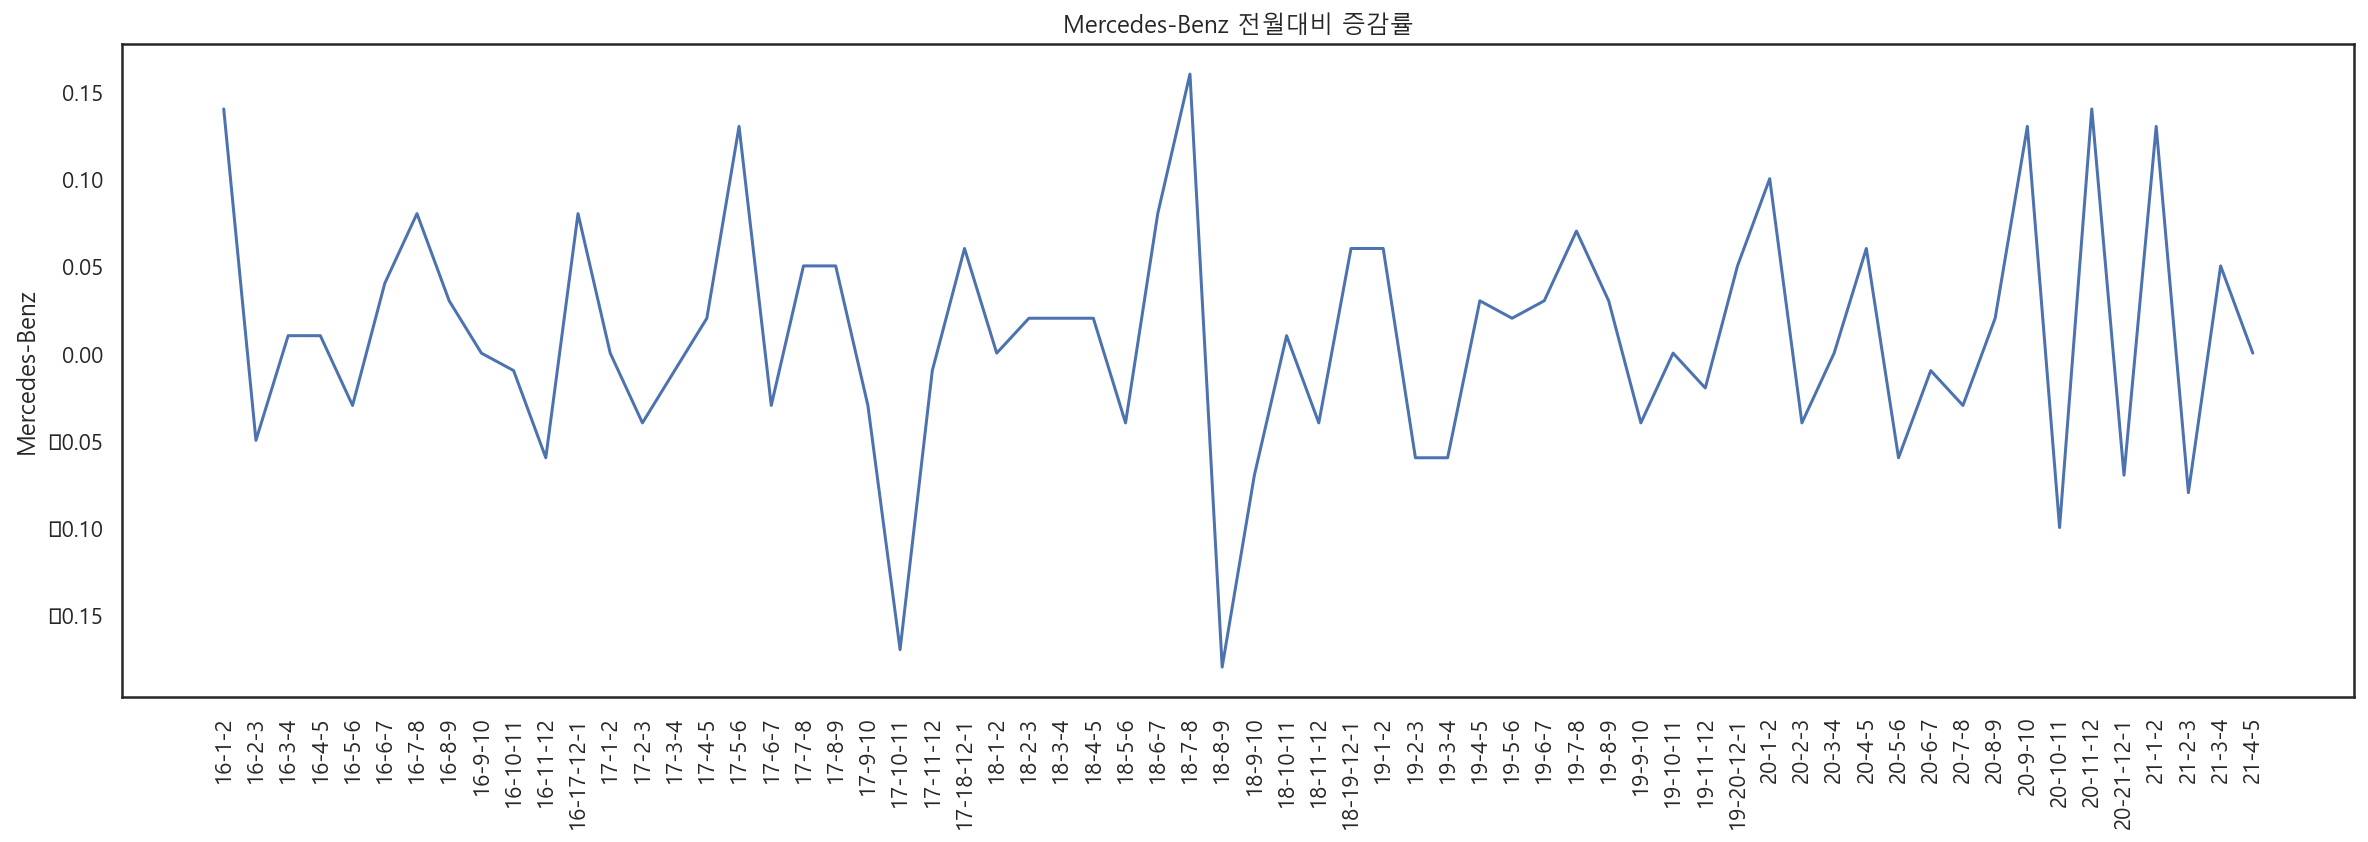

In [37]:
plt.figure(figsize=(20, 6))

sns.lineplot(data=test_percent_df, x=test_percent_df.index, y='Mercedes-Benz')
plt.title('Mercedes-Benz 전월대비 증감률')
plt.xticks(rotation=90)

plt.show()